# Part I: Dataset1

**1.Load the data file into a Spark DataFrame (1st DataFrame) and describe its structure**

In [1]:
# Install PySpark
!pip install pyspark


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488493 sha256=f1e1767c9453a74a8cf392600ca9c3c678a414af691977beb6f49298a5110e62
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

In [3]:
# Initialize Spark session
spark = SparkSession.builder.appName("BigDataAnalytics").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/07/25 19:53:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
# Load the CSV file into a Spark DataFrame
df1 = spark.read.csv("/kaggle/input/dataset1-csv/dataset1.csv", header=True, inferSchema=True)


In [5]:
#  structure of the DataFrame
df1.printSchema()
df1.show(5)


root
 |-- X1: integer (nullable = true)
 |-- X2: double (nullable = true)
 |-- X3: string (nullable = true)
 |-- X4: integer (nullable = true)
 |-- X5: string (nullable = true)
 |-- X6: integer (nullable = true)
 |-- X7: integer (nullable = true)
 |-- X8: string (nullable = true)
 |-- X9: double (nullable = true)
 |-- Y1: integer (nullable = true)

+---+------+----+---+---+---+---+---+----+---+
| X1|    X2|  X3| X4| X5| X6| X7| X8|  X9| Y1|
+---+------+----+---+---+---+---+---+----+---+
| 59|28.378|0.34|204|196|132| 49| 92| 7.7|  1|
| 59|24.968|   1|147|181|129| 34| 96|4.09|  1|
| 48|31.307|0.62|155|185|127| 41|139| 4.5|  1|
| 47|27.837|0.38|488|254|158| 55|250| 5.3|  2|
| 55|22.662|0.49| 87|175|120| 44| 99| 6.9|  1|
+---+------+----+---+---+---+---+---+----+---+
only showing top 5 rows



In [6]:
# Number of rows and columns
print(f"Number of rows: {df1.count()}")
print(f"Number of columns: {len(df1.columns)}")

Number of rows: 6967
Number of columns: 10


**2. Create a new DataFrame (2nd DataFrame) by removing all rows with null/missing values and calculate the number of rows removed**

In [7]:
# Remove rows with null values
df2 = df1.dropna()



In [8]:
# Calculate the number of rows removed
rows_removed = df1.count() - df2.count()

print(f"Number of rows removed: {rows_removed}")


Number of rows removed: 0


**3. Calculate summary statistics of the ‘X1’ feature, generate a histogram, and describe the distribution**

+-------+-----------------+
|summary|               X1|
+-------+-----------------+
|  count|             6967|
|   mean|53.33156308310607|
| stddev|8.715031757570447|
|    min|               21|
|    max|               90|
+-------+-----------------+



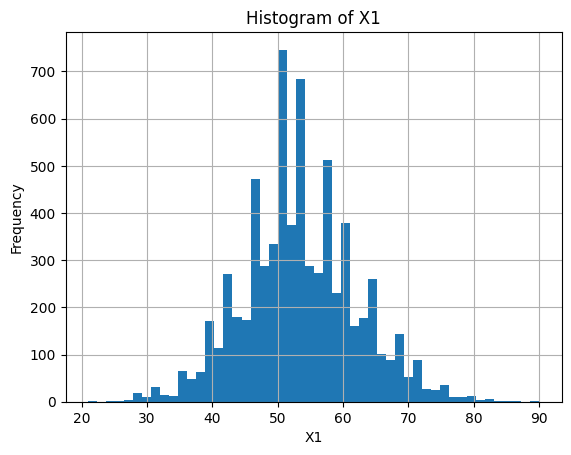

In [9]:
# Calculate summary statistics for X1
summary_stats = df2.describe("X1").show()

# Convert to Pandas for plotting
import matplotlib.pyplot as plt

x1_pd = df2.select("X1").toPandas()
x1_pd.hist(column='X1', bins=50)
plt.xlabel("X1")
plt.ylabel("Frequency")
plt.title("Histogram of X1")
plt.show()



In [10]:
# Additional statistics
from pyspark.sql.functions import mean, stddev, variance, expr

mean_val = df2.select(mean("X1")).collect()[0][0]
stddev_val = df2.select(stddev("X1")).collect()[0][0]
variance_val = df2.select(variance("X1")).collect()[0][0]
median_val = df2.approxQuantile("X1", [0.5], 0.0)[0]

print(f"Mean: {mean_val}, Std Dev: {stddev_val}, Variance: {variance_val}, Median: {median_val}")


Mean: 53.33156308310607, Std Dev: 8.715031757570447, Variance: 75.95177853546144, Median: 53.0


**4. Display the quartile info of the ‘X2’ feature and generate a boxplot**

25th percentile: 22.976, 50th percentile (median): 24.697, 75th percentile: 26.435


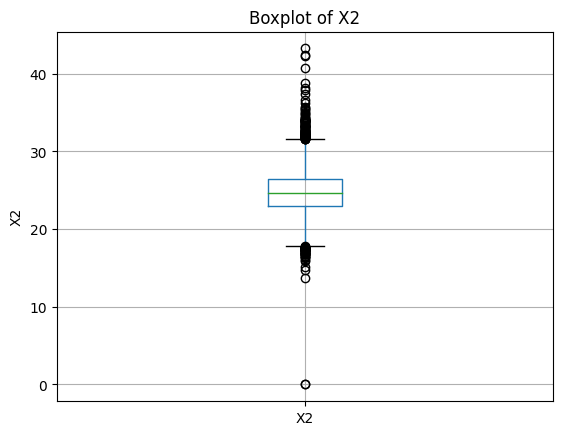

In [11]:


# Display quartile info
quantiles = df2.approxQuantile("X2", [0.25, 0.5, 0.75], 0.0)
print(f"25th percentile: {quantiles[0]}, 50th percentile (median): {quantiles[1]}, 75th percentile: {quantiles[2]}")

# Convert to Pandas for plotting
x2_pd = df2.select("X2").toPandas()
x2_pd.boxplot(column='X2')
plt.ylabel("X2")
plt.title("Boxplot of X2")
plt.show()



**5. Count the number of rows where ‘X1’ is greater than 50 and ‘Y1’ equals 1**

In [12]:
# Count the rows meeting the criteria
count_rows = df2.filter((col("X1") > 50) & (col("Y1") == 1)).count()
print(f"Number of rows where X1 > 50 and Y1 == 1: {count_rows}")


Number of rows where X1 > 50 and Y1 == 1: 2182


**7. Build two classification models using ‘Y1’ as the target label and evaluate their performance**

In [13]:
# Import necessary libraries for machine learning
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [14]:
# Encode string columns
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df2) for column in ["X3", "X5", "X8"]]
for indexer in indexers:
    df2 = indexer.transform(df2)

In [15]:
# Prepare the data for modeling
feature_columns = [col for col in df2.columns if col != "Y1" and col not in ["X3", "X5", "X8"]]
feature_columns += ["X3_index", "X5_index", "X8_index"]

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df2_features = assembler.transform(df2)


In [16]:
# Split the data into training and test sets
train_df, test_df = df2_features.randomSplit([0.7, 0.3], seed=42)

In [17]:
# Train Logistic Regression model
lr = LogisticRegression(labelCol="Y1", featuresCol="features")
lr_model = lr.fit(train_df)

24/07/25 19:54:09 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


In [18]:
# Train Random Forest model with increased maxBins
rf = RandomForestClassifier(labelCol="Y1", featuresCol="features", numTrees=100, maxBins=250)
rf_model = rf.fit(train_df)


24/07/25 19:54:21 WARN DAGScheduler: Broadcasting large task binary with size 1627.5 KiB


In [19]:
# Evaluate the models
evaluator = MulticlassClassificationEvaluator(labelCol="Y1", metricName="accuracy")


In [20]:
# Logistic Regression evaluation
lr_predictions = lr_model.transform(test_df)
lr_accuracy = evaluator.evaluate(lr_predictions)
print(f"Logistic Regression Accuracy: {lr_accuracy}")


Logistic Regression Accuracy: 0.6231738035264484


In [21]:
# Random Forest evaluation
rf_predictions = rf_model.transform(test_df)
rf_accuracy = evaluator.evaluate(rf_predictions)
print(f"Random Forest Accuracy: {rf_accuracy}")

24/07/25 19:54:25 WARN DAGScheduler: Broadcasting large task binary with size 1783.3 KiB


Random Forest Accuracy: 0.6080604534005037
